## CSCS530 Winter 2017
#### Complex Systems 530 - Computer Modeling of Complex Systems (Winter 2017)

  * Course ID: CMPLXSYS 530
  * Course Title: Computer Modeling of Complex Systems
  * Term: Winter 2017
  * Schedule: Wednesdays and Friday, 1:00-2:30PM ET

#### [View this repository on NBViewer](http://nbviewer.jupyter.org/github/lynetteshaw/cscs-530-wi2017/tree/master/)

# Schelling Model (basic)


### Model Description

In "Dynamics Models of Segregation" (1971), Thomas Schelling describes a model of how moderate preferences at the individual level can give rise to emergent patterns of seperation. At the beginning of Chapter 10 in  _Think Complexity_ (p. 91), Downey describes the model as follows:

&nbsp; 



> The Schelling model of the world is a grid; each cell represents a house. The houses are occupied by two kinds of “agents,” labeled red and blue, in roughly equal numbers. About 10% of the houses are empty.

> At any point in time, an agent might be happy or unhappy, depending on the other agents in the neighborhood. The neighborhood of each house is the set of eight adjacent cells. In one version of the model, agents are happy if they have at least two neighbors like themselves, and unhappy if they have one or zero.

> The simulation proceeds by choosing an agent at random and checking to see whether it is
happy. If so, then nothing happens; if not, the agent chooses one of the unoccupied cells at
random and moves.

&nbsp; 


The goal of the ABM present here is to implement a basic version of this model and demonstrate how these emergent patterns arise.

In [1]:
%matplotlib inline

# Imports
import copy
import itertools

import numpy
import matplotlib.pyplot as plt
import pandas


# Import widget methods
#from IPython.html.widgets import *
from  ipywidgets import *

## Building a grid

&nbsp; 

In the sample below, we'll create a simple square grid and fill the grid with households.  The parameters below will guide our model as follows:
  
  * __``grid_size``__: the number of cells per row or column; the total number of cells is $grid\_size^2$.
  * __``group_proportion``__: the percentage of households that will be of type 1
  * __``density``__: the percentage of grid cells that will be populated with a household
  
&nbsp; 

The logic for our grid initialization can be described as follows:
  
  * For each cell in every row and column
      * Draw a random value on $[0, 1)$ and compare to $density$ to determine if we will fill this cell
      * If the cell will be filled, draw a random value on $[0, 1)$ and compare to $group\_proportion$ to determine whether the household will be 1 or 2

&nbsp; 

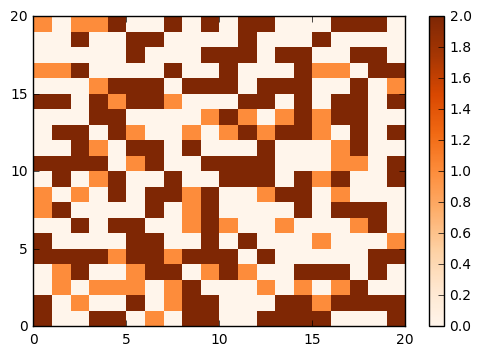

In [2]:
# Set parameters
grid_size = 20
group_proportion = 0.25
density = 0.5

# Create the space and activate random cells
space = numpy.zeros((grid_size, grid_size), dtype=numpy.int8)

# Now sample the agents.
for row_id in range(grid_size):
    for col_id in range(grid_size):
        # Determine if this cell will be populated
        if numpy.random.random() <= density:
            # Determine this cell's initial group
            if numpy.random.random() <= group_proportion:
                cell_type = 1
            else:
                cell_type = 2
            
            # Set the space
            space[row_id, col_id] = cell_type
        
# Now show the space
f = plt.figure()
p = plt.pcolor(space, cmap = "Oranges", snap=True)
c = plt.colorbar()

### Initialization method

  Below, we wrap the test method above in a method named ``initialize_space``.  We need to setup the following parameters:
  
  * __``grid_size``__: number of cells in each row or column
  * __``group_proportion``__: percentage of initial population that will be of group 1
  * __``density``__: percentage of cells that will be occupied in the space

In [3]:
def initialize_space(grid_size, group_proportion, density):
    """
    Initialize a space.
    """
    
    # Create the space and activate random cells
    space = numpy.zeros((grid_size, grid_size), dtype=numpy.int8)

    # Now sample the agents.
    for row_id in range(grid_size):
        for col_id in range(grid_size):
            # Determine if this cell will be populated
            if numpy.random.random() <= density:
                # Determine this cell's initial group
                if numpy.random.random() <= group_proportion:
                    cell_type = 1
                else:
                    cell_type = 2

                # Set the cell
                space[row_id, col_id] = cell_type

    return space

### Testing out space initialization

  Let's test out our ``initialize_space`` method by visualizing for given parameters below.

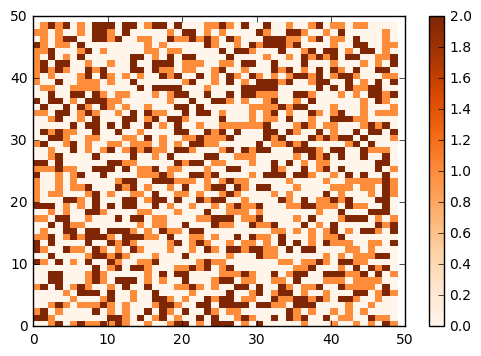

In [36]:
# Set parameters
grid_size = 10
group_proportion = 0.25
happy_proportion = 0.5
density = 0.5
window = 1

def display_space(grid_size=10, group_proportion=0.5, density=0.5):
    # Check
    assert(grid_size > 1)
    assert(group_proportion >= 0.0)
    assert(group_proportion <= 1.0)
    assert(density >= 0.0)
    assert(density <= 1.0)

    # Initialize space
    space = initialize_space(grid_size, group_proportion, density)

    # Plot
    f = plt.figure()
    p = plt.pcolor(space, cmap = "Oranges")
    c = plt.colorbar()

# Setup widget
interact(display_space,
         grid_size= widgets.IntSlider(min=2, max=100, value=10),
         group_proportion= widgets.FloatSlider(min=0.0, max=1.0, value=0.5),
         density= widgets.FloatSlider(min=0.0, max=1.0, value=0.5))

In [55]:
### Thinking through how to get neighbor counts and fraction similar

grid_size = 20
group_proportion = 0.25
happy_proportion = 0.5
density = 0.5
window = 1
space = initialize_space(grid_size, group_proportion, density)


# Pick a random household
household_list = numpy.column_stack(numpy.where(space > 0))
household_id = numpy.random.choice(range(len(household_list)))

# Check if the household is happy
row, col = household_list[household_id]
household_type = space[row, col]

# Get the set of positions with grid wrapping for neighbors
neighbor_pos = [(x % grid_size, y % grid_size)
                for x, y in itertools.product(range(row-window, row+window+1),
                                              range(col-window, col+window+1))]
neighborhood = numpy.reshape([space[x, y] for x, y in neighbor_pos],
              (2*window+1, 2*window+1))

# Count the number of neighbors of same type
neighbor_count = len(numpy.where(neighborhood == household_type)[0]) - 1
neighbor_fraction = float(neighbor_count) / ((2 * window + 1) **2 - 1)

# Output counts
print("Household type: {0}".format(household_type))
print("Neighborhood:")
print(neighborhood)
print("Number of similar neighbors:")
print(neighbor_count)
print("Fraction of similar neighbors:")
print(neighbor_fraction)

Household type: 1
Neighborhood:
[[0 0 2]
 [2 1 0]
 [1 0 0]]
Number of similar neighbors:
1
Fraction of similar neighbors:
0.125


In [49]:
def run_model_step(space, happy_proportion, window):
    """
    Run  a step of the model.
    """
    space = copy.copy(space)
    grid_size = space.shape[0]
    
    # Get list of empty and occupied
    household_list = numpy.column_stack(numpy.where(space > 0))
    
    # Pick a random house
    household_id = numpy.random.choice(range(len(household_list)))

    # Check if the household is happy
    row, col = household_list[household_id]
    household_type = space[row, col]
    
    # Get the set of positions with grid wrapping for neighbors
    neighbor_pos = [(x % grid_size, y % grid_size)
                    for x, y in itertools.product(range(row-window, row+window+1),
                                                  range(col-window, col+window+1))]
    neighborhood = numpy.reshape([space[x, y] for x, y in neighbor_pos],
                  (2*window+1, 2*window+1))

    # Count the number of neighbors of same type
    neighbor_count = len(numpy.where(neighborhood == household_type)[0]) - 1
    neighbor_fraction = float(neighbor_count) / ((2 * window + 1) **2 - 1)
    
    # If the house is unhappy, move.
    if neighbor_fraction < happy_proportion:
        # Get empty cells
        empty_list = numpy.column_stack(numpy.where(space == 0))
        
        # Get empty target cell
        target_cell_id = numpy.random.choice(range(len(empty_list)))
        target_row, target_col = empty_list[target_cell_id]
        
        # Move the agent
        space[row, col] = 0
        space[target_row, target_col] = household_type

    return space

In [50]:
# Set parameters
grid_size = 50
group_proportion = 0.33
happy_proportion = 0.33
density = 0.5
window = 3
max_steps = 100000

# Initialize space
space = initialize_space(grid_size, group_proportion, density)

# Setup space
space_history = [space]

# Iterate
for i in range(max_steps):
    # Append step history
    space_history.append(run_model_step(space_history[-1],
                                        happy_proportion,
                                        window))

In [ ]:
def display_space_step(step=1):
    f = plt.figure()
    plt.pcolor(space_history[step], cmap="Oranges")
    plt.colorbar()
    ax = f.gca()
    ax.set_aspect(1./ax.get_data_ratio())   

In [ ]:
interact(display_space_step,
                step=widgets.IntSlider(min=1, max=len(space_history)-1,
                                     step=1))

### Automate simulation

In [ ]:
%%time

def run_model_simulation(grid_size = 50, group_proportion = 0.33, happy_proportion = 0.33,
                         density = .90, window = 1, max_steps = 100000):
    """
    Run a full model simulation.
    """

    # Initialize space
    space = initialize_space(grid_size, group_proportion, density)

    # Setup space
    space_history = [space]

    # Iterate
    for i in range(max_steps):
        # Append step history
        space_history.append(run_model_step(space_history[-1],
                                            happy_proportion,
                                            window))

    return space_history

# Run the simulation and output
space_history = run_model_simulation(grid_size=25, happy_proportion=0.50, window=1, max_steps=10000)
interact(display_space_step,
                step= widgets.IntSlider(min=1, max=len(space_history)-1,
                                     step=1))

In [ ]:
space_history[9999][9,11]

In [ ]:
def get_neighbor_distribution(space, window=1):
    """
    Get distribution of neighbor fractions.
    """
    
    fractions = numpy.full(space.shape, numpy.nan)
    grid_size = space.shape[0]
    
    # Get a measure of clustering
    for row in range(grid_size):
        for col in range(grid_size):
            # Check if cell is occupied
            if space[row, col] == 0:
                continue
            else:
                household_type = space[row, col]
                
            neighbor_pos = [1 for x, y in itertools.product(range(row-window, row+window+1),
                                                          range(col-window, col+window+1))
                               if space[x % grid_size, y % grid_size] == household_type]
            fractions[row, col] = float(sum(neighbor_pos)-1) / ((2 * window + 1) **2 - 1)
    
    return fractions

# Get the degree of clustering at each time step
cluster_history = []
cluster_mean_ts = []
for step in range(len(space_history)):
    cluster_history.append(get_neighbor_distribution(space_history[step]))
    cluster_mean_ts.append(numpy.nanmean(cluster_history[-1]))

In [ ]:
cluster_history[9999][9, 11]



In [ ]:
# Method to plot clustering surface
def display_cluster_step(step=1):
    # Create figures
    f = plt.figure()
    plt.imshow(cluster_history[step], interpolation = "nearest", cmap='RdBu')
    plt.colorbar()
    

# Create widget
interact(display_cluster_step,
            step=widgets.IntSlider(min=1, max=len(cluster_history)-1,
                                 step=1))

In [ ]:
# Plot the average time series
f = plt.figure()
plt.plot(range(len(cluster_mean_ts)), cluster_mean_ts)

Copyright (c) 2014, Michael Bommarito All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

- Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

- Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE